In [1]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv("/content/twitter_training.csv")
df_val = pd.read_csv("/content/twitter_validation.csv")

In [3]:
df_train.columns = ['ID', 'Entity', 'Sentiment', 'Text']
df_val.columns = ['ID', 'Entity', 'Sentiment', 'Text']

In [4]:
df_all = pd.concat([df_train, df_val], ignore_index=True)

In [5]:
df_all.shape

(75680, 4)

In [6]:
df_all.head()

,ID,Entity,Sentiment,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
df_all.isna().sum()

,0
ID,0
Entity,0
Sentiment,0
Text,686


In [8]:
df_all.duplicated().sum()

np.int64(3216)

In [9]:
df_all.dropna(inplace=True)
df_all.drop_duplicates(inplace=True)
df_all.shape

(72138, 4)

In [10]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_all['Text'], df_all['Sentiment'],
    test_size=0.30,
    random_state=42,
    stratify=df_all['Sentiment']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=1/3,
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")

Train size: 50496
Validation size: 14428
Test size: 7214


In [11]:
df_train_split = pd.DataFrame({'Text': train_texts, 'Sentiment': train_labels})
df_val_split = pd.DataFrame({'Text': val_texts, 'Sentiment': val_labels})
df_test_split = pd.DataFrame({'Text': test_texts, 'Sentiment': test_labels})

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train_split['Text'] = df_train_split['Text'].apply(clean_text)
df_val_split['Text'] = df_val_split['Text'].apply(clean_text)
df_test_split['Text'] = df_test_split['Text'].apply(clean_text)

In [13]:
label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(df_train_split['Sentiment'])
val_labels_enc = label_encoder.transform(df_val_split['Sentiment'])
test_labels_enc = label_encoder.transform(df_test_split['Sentiment'])
num_labels = len(label_encoder.classes_)

print("Classes:", label_encoder.classes_)
print("Number of classes:", num_labels)

Classes: ['Irrelevant' 'Negative' 'Neutral' 'Positive']
Number of classes: 4


In [14]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 128

train_encodings = tokenizer(
    list(df_train_split['Text']),
    truncation=True,
    padding='max_length',
    max_length=max_length
)

val_encodings = tokenizer(
    list(df_val_split['Text']),
    truncation=True,
    padding='max_length',
    max_length=max_length
)

test_encodings = tokenizer(
    list(df_test_split['Text']),
    truncation=True,
    padding='max_length',
    max_length=max_length
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.convert_to_tensor(train_labels_enc)
)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    tf.convert_to_tensor(val_labels_enc)
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.convert_to_tensor(test_labels_enc)
)).batch(16)

In [16]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    from_pt=True
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [19]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=1
)

Epoch 1/5
3156/3156 [==============================] - 1509s 460ms/step - loss: 0.8369 - accuracy: 0.6663 - val_loss: 0.5481 - val_accuracy: 0.7958
Epoch 2/5
3156/3156 [==============================] - 1439s 456ms/step - loss: 0.3505 - accuracy: 0.8716 - val_loss: 0.3743 - val_accuracy: 0.8798
Epoch 3/5
3156/3156 [==============================] - 1438s 456ms/step - loss: 0.1858 - accuracy: 0.9317 - val_loss: 0.3397 - val_accuracy: 0.8899
Epoch 4/5
3156/3156 [==============================] - 1447s 458ms/step - loss: 0.1464 - accuracy: 0.9437 - val_loss: 0.3270 - val_accuracy: 0.8965
Epoch 5/5
3156/3156 [==============================] - 1439s 456ms/step - loss: 0.1217 - accuracy: 0.9533 - val_loss: 0.3362 - val_accuracy: 0.9012


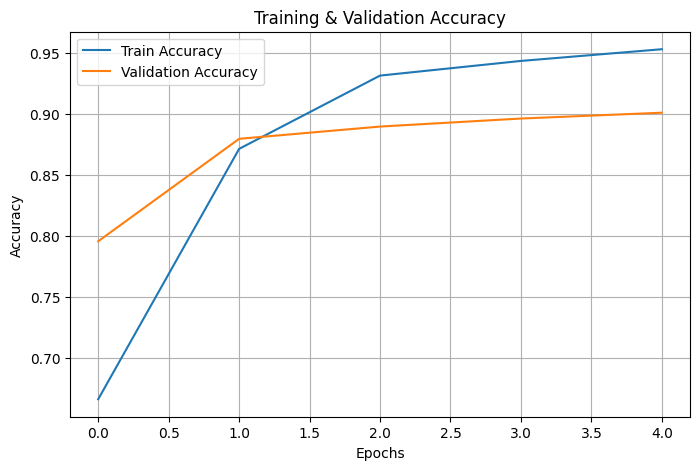

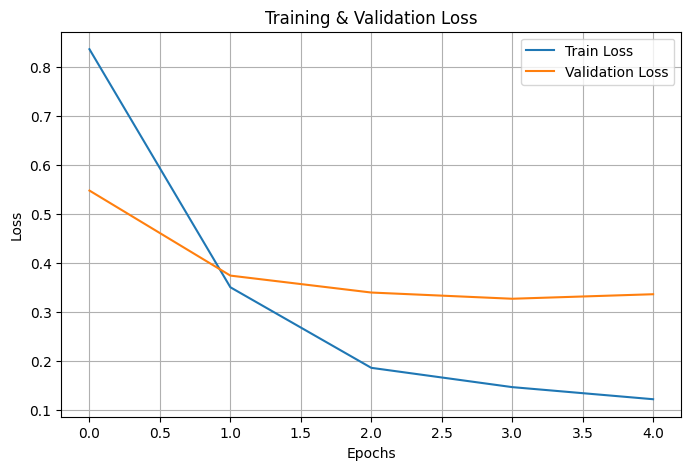

In [20]:
# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

451/451 [==============================] - 69s 152ms/step - loss: 0.3262 - accuracy: 0.9038
Test Loss: 0.3262
Test Accuracy: 0.9038


In [22]:
preds = model.predict(test_dataset)
pred_labels = np.argmax(preds.logits, axis=1)

print(classification_report(test_labels_enc, pred_labels, target_names=label_encoder.classes_))

451/451 [==============================] - 72s 152ms/step
              precision    recall  f1-score   support

  Irrelevant       0.91      0.87      0.89      1262
    Negative       0.92      0.92      0.92      2179
     Neutral       0.89      0.91      0.90      1788
    Positive       0.89      0.90      0.90      1985

    accuracy                           0.90      7214
   macro avg       0.90      0.90      0.90      7214
weighted avg       0.90      0.90      0.90      7214



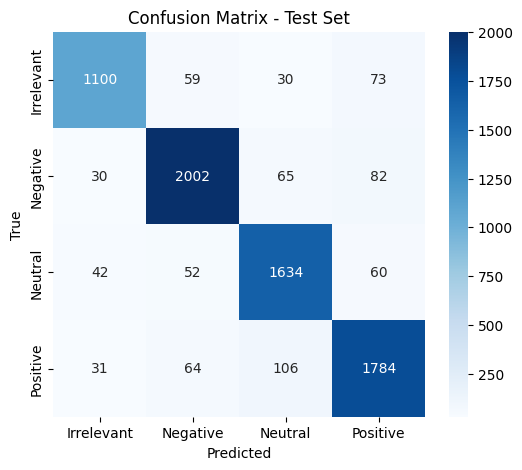

In [23]:
cm = confusion_matrix(test_labels_enc, pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()


In [24]:
model.save_pretrained("sentiment_bert_model")
tokenizer.save_pretrained("sentiment_bert_tokenizer")

('sentiment_bert_tokenizer/tokenizer_config.json',
 'sentiment_bert_tokenizer/special_tokens_map.json',
 'sentiment_bert_tokenizer/vocab.txt',
 'sentiment_bert_tokenizer/added_tokens.json',
 'sentiment_bert_tokenizer/tokenizer.json')

In [26]:
!zip -r sentiment_bert_tokenizer.zip /content/sentiment_bert_tokenizer

  adding: content/sentiment_bert_tokenizer/ (stored 0%)
  adding: content/sentiment_bert_tokenizer/tokenizer_config.json (deflated 75%)
  adding: content/sentiment_bert_tokenizer/special_tokens_map.json (deflated 42%)
  adding: content/sentiment_bert_tokenizer/vocab.txt (deflated 53%)
  adding: content/sentiment_bert_tokenizer/tokenizer.json (deflated 71%)
